In [1]:
!git clone https://github.com/Olyco/EasyTSF.git

Cloning into 'EasyTSF'...
remote: Enumerating objects: 368, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 368 (delta 42), reused 10 (delta 10), pack-reused 291 (from 1)
Receiving objects: 100% (368/368), 1.69 MiB | 21.96 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install -r "EasyTSF/requirements.txt"

In [2]:
!pip install ray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 MB 169.6 MB/s eta 0:00:00


In [3]:
!pip install pykan

In [ ]:
!python EasyTSF/train.py -c EasyTSF/config/reproduce_conf/KAN/ETTh1_96for48.py

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
checkpoint directory created: drive/MyDrive/VKR/Results/save/110525_1424/model
saving model version 0.0
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | MultKAN | 334 K  | train
1 | loss_function | MSELoss | 0      | train
--------------------------------------------------
282 K     Trainable params
52.1 K    Non-trainable params
334 K     Total params
1.336     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
Epoch 0: 100% 134/134 [44:16<00:00, 19.83s/it, v_num=ed_1, train/loss_step=1.060]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation:   0% 0/45 [00:00<?, ?it/s]       
Validation DataLoader 0:   0% 0/45 [00:00<?, ?it/s]
Validation DataLoader 0:  44% 20/45 [01:23<01:43,  4.15s/it]
Valida

In [4]:
!python EasyTSF/train.py -c EasyTSF/config/reproduce_conf/KAN/ETTh1_48for12.py

Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
checkpoint directory created: drive/MyDrive/VKR/Results/save/110525_2132/model
saving model version 0.0
You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type    | Params | Mode 
--------------------------------------------------
0 | model         | MultKAN | 121 K  | train
1 | loss_function | MSELoss | 0      | train
--------------------------------------------------
100 K     Trainable params
20.8 K    Non-trainable params
121 K     Total params
0.486     Total estimated model params size (MB)
9     

In [ ]:
!python EasyTSF/train.py -c EasyTSF/config/reproduce_conf/MLP/ETTh1_48for12.py

In [ ]:
exp_conf = dict(
    model_name="KAN",
    dataset_name='ETTh1',

    hist_len=96,
    pred_len=48,

    max_epochs=3,

    width=[96 * 7, 50, 50 , 48 * 7],
    grid=3,
    k=3,

    lr=0.01,

    save_root="./save",

    batch_size=64,
    optimizer="AdamW",
    optimizer_betas=(0.95, 0.9),
    optimizer_weight_decay=1e-5,
    lr_scheduler='StepLR',
    lr_step_size=1,
    lr_gamma=0.5,
    gradient_clip_val=5,
    val_metric="val/loss",
    test_metric="test/mae",
    es_patience=10,

    norm_time_feature=False,
    time_feature_cls=["tod", "dow"],

    num_workers=2,

    var_num=7,
    freq=60,
    data_split=[8640, 2880, 2880],
    data_root="EasyTSF/dataset",
    devices="auto",

    include_time_feature = False,

)


In [ ]:
import os

import lightning.pytorch as pl
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from torch.utils.data import Dataset


class GeneralTSFDataset(Dataset):
    def __init__(self, hist_len, pred_len, variable, time_feature, model_name, include_time_feature):
        self.hist_len = hist_len
        self.pred_len = pred_len
        self.variable = variable
        self.time_feature = time_feature
        self.model_name = model_name
        self.include_time_feature = include_time_feature

    def __getitem__(self, index):
        hist_start = index
        hist_end = index + self.hist_len
        pred_end = hist_end + self.pred_len

        var_x = self.variable[hist_start:hist_end, ...]
        tf_x = self.time_feature[hist_start:hist_end, ...]

        var_y = self.variable[hist_end:pred_end, ...]
        tf_y = self.time_feature[hist_end:pred_end, ...]

        if self.include_time_feature: # static features should not be forecasted
          # concatenate all features
          var_x = np.concatenate((var_x, tf_x), axis=-1)
          var_y = np.concatenate((var_y, tf_y), axis=-1)


        if self.model_name == "KAN":
          var_x = var_x.reshape(-1)
          var_y = var_y.reshape(-1)

        return var_x, var_y

    def __len__(self):
        return len(self.variable) - (self.hist_len + self.pred_len) + 1


class DataInterface(pl.LightningDataModule):

    def __init__(self, **kwargs):
        super().__init__()
        self.num_workers = kwargs['num_workers']
        self.batch_size = kwargs['batch_size']
        self.hist_len = kwargs['hist_len']
        self.pred_len = kwargs['pred_len']
        self.norm_time_feature = kwargs['norm_time_feature']
        self.train_len, self.val_len, self.test_len = kwargs['data_split']
        self.time_feature_cls = kwargs['time_feature_cls']

        self.data_path = os.path.join(kwargs['data_root'], "{}.npz".format(kwargs['dataset_name']))
        self.config = kwargs

        self.variable, self.time_feature = self.__read_data__()

    def __read_data__(self):
        data = np.load(self.data_path)
        variable = data['variable']
        timestamp = pd.DatetimeIndex(data['timestamp'])

        # time_feature
        time_feature = []
        for tf_cls in self.time_feature_cls:
            if tf_cls == "tod":
                tod_size = int((24 * 60) / self.config['freq']) - 1
                tod = np.array(list(map(lambda x: ((60 * x.hour + x.minute) / self.config['freq']), timestamp)))
                if self.norm_time_feature:
                    time_feature.append(tod / tod_size)
                else:
                    time_feature.append(tod)
            elif tf_cls == "dow":
                dow_size = 7 - 1
                dow = np.array(timestamp.dayofweek)  # 0 ~ 6
                if self.norm_time_feature:
                    time_feature.append(dow / dow_size)
                else:
                    time_feature.append(dow)
            elif tf_cls == "dom":
                dom_size = 31 - 1
                dom = np.array(timestamp.day) - 1  # 0 ~ 30
                if self.norm_time_feature:
                    time_feature.append(dom / dom_size)
                else:
                    time_feature.append(dom)
            elif tf_cls == "doy":
                doy_size = 366 - 1
                doy = np.array(timestamp.dayofyear) - 1  # 0 ~ 181
                if self.norm_time_feature:
                    time_feature.append(doy / doy_size)
                else:
                    time_feature.append(doy)
            else:
                raise NotImplementedError

        return variable, np.stack(time_feature, axis=-1)


    def train_dataloader(self):
        return DataLoader(
            dataset=GeneralTSFDataset(
                self.hist_len,
                self.pred_len,
                self.variable[:self.train_len].copy(),
                self.time_feature[:self.train_len].copy(),
                self.config["model_name"],
                self.config['include_time_feature'],
            ),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=True
        )

    def val_dataloader(self):
        return DataLoader(
            dataset=GeneralTSFDataset(
                self.hist_len,
                self.pred_len,
                self.variable[self.train_len - self.hist_len:self.train_len + self.val_len].copy(),
                self.time_feature[self.train_len - self.hist_len:self.train_len + self.val_len].copy(),
                self.config["model_name"],
                self.config['include_time_feature'],
            ),
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            drop_last=False
        )

    def test_dataloader(self):
        return DataLoader(
            dataset=GeneralTSFDataset(
                self.hist_len,
                self.pred_len,
                self.variable[self.train_len + self.val_len - self.hist_len:].copy(),
                self.time_feature[self.train_len + self.val_len - self.hist_len:].copy(),
                self.config["model_name"],
                self.config['include_time_feature'],
            ),
            batch_size=1,
            num_workers=self.num_workers,
            shuffle=False
        )


ModuleNotFoundError: No module named 'lightning'

In [ ]:
data_module = DataInterface(**exp_conf)
print(data_module.time_feature.shape)

(14400, 2)


In [ ]:
train_loader = data_module.train_dataloader()
len(train_loader)

132

In [ ]:
for i, batch in enumerate(train_loader):
  if i == 0:
    var_x, var_y = [_.float() for _ in batch]
    print(var_x.shape, var_y.shape)
    # print(var_x[0], marker_x[0], var_y[0], marker_y[0])

torch.Size([64, 672]) torch.Size([64, 336])


In [ ]:
var_x[0].shape

torch.Size([672])

In [ ]:
var_y[:, -48:].shape

torch.Size([64, 48])

In [ ]:
import importlib
import inspect
import os

import lightning.pytorch as L
import numpy as np
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lrs

from kan import KAN


class LTSFRunner(L.LightningModule):
    def __init__(self, **kargs):
        super().__init__()
        self.save_hyperparameters()
        self.load_model()
        self.configure_loss()

        stat = np.load(os.path.join(self.hparams.data_root, '{}.npz'.format(self.hparams.dataset_name)))
        self.register_buffer('mean', torch.tensor(stat['mean']).float())
        self.register_buffer('std', torch.tensor(stat['std']).float())

    def forward(self, batch, batch_idx):
        var_x, marker_x, var_y, marker_y = [_.float() for _ in batch]
        if self.hparams.model_name == "KAN":
          print(var_x.shape, marker_x.shape, var_y.shape, marker_y.shape)

          label = var_y[:, -self.hparams.pred_len:]
          prediction = self.model(var_x, marker_x)[:, -self.hparams.pred_len:]
        else:
          label = var_y[:, -self.hparams.pred_len:, :]
          prediction = self.model(var_x, marker_x)[:, -self.hparams.pred_len:, :]
        return prediction, label

    def training_step(self, batch, batch_idx):
        loss = self.loss_function(*self.forward(batch, batch_idx))
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.loss_function(*self.forward(batch, batch_idx))
        self.log('val/loss', loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def test_step(self, batch, batch_idx):
        prediction, label = self.forward(batch, batch_idx)
        mae = torch.nn.functional.l1_loss(prediction, label)
        mse = torch.nn.functional.mse_loss(prediction, label)
        self.log('test/mae', mae, on_step=False, on_epoch=True, sync_dist=True)
        self.log('test/mse', mse, on_step=False, on_epoch=True, sync_dist=True)

    def configure_loss(self):
        self.loss_function = nn.MSELoss()

    def configure_optimizers(self):
        if self.hparams.optimizer == 'Adam':
            optimizer = torch.optim.Adam(
                self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.optimizer_weight_decay)
        elif self.hparams.optimizer == 'AdamW':
            optimizer = torch.optim.AdamW(
                self.parameters(), lr=self.hparams.lr, betas=(0.9, 0.95), weight_decay=1e-5)
        else:
            raise ValueError('Invalid optimizer type!')

        if self.hparams.lr_scheduler == 'StepLR':
            lr_scheduler = {
                "scheduler": lrs.StepLR(
                    optimizer, step_size=self.hparams.lr_step_size, gamma=self.hparams.lr_gamma)
            }
        elif self.hparams.lr_scheduler == 'MultiStepLR':
            lr_scheduler = {
                "scheduler": lrs.MultiStepLR(
                    optimizer, milestones=self.hparams.milestones, gamma=self.hparams.gamma)
            }
        elif self.hparams.lr_scheduler == 'ReduceLROnPlateau':
            lr_scheduler = {
                "scheduler": lrs.ReduceLROnPlateau(
                    optimizer, mode='min', factor=self.hparams.lrs_factor, patience=self.hparams.lrs_patience),
                "monitor": self.hparams.val_metric
            }
        elif self.hparams.lr_scheduler == 'WSD':
            assert self.hparams.lr_warmup_end_epochs < self.hparams.lr_stable_end_epochs < self.hparams.max_epochs

            def wsd_lr_lambda(epoch):
                if epoch < self.hparams.lr_warmup_end_epochs:
                    return (epoch + 1) / self.hparams.lr_warmup_end_epochs
                if self.hparams.lr_warmup_end_epochs <= epoch < self.hparams.lr_stable_end_epochs:
                    return 1.0
                if self.hparams.lr_stable_end_epochs <= epoch <= self.hparams.max_epochs:
                    return (epoch + 1 - self.hparams.lr_stable_end_epochs) / (
                            self.hparams.max_epochs - self.hparams.lr_stable_end_epochs)

            lr_scheduler = {
                "scheduler": lrs.LambdaLR(optimizer, lr_lambda=wsd_lr_lambda),
            }
        else:
            raise ValueError('Invalid lr_scheduler type!')

        return {
            "optimizer": optimizer,
            "lr_scheduler": lr_scheduler,
        }

    def load_model(self):
        model_name = self.hparams.model_name
        if model_name == "KAN":
          self.model = self.instancialize(KAN)
        else:
          Model = getattr(importlib.import_module('.' + model_name, package='easytsf.model'), model_name)
          self.model = self.instancialize(Model)

    def instancialize(self, Model):
        """ Instancialize a model using the corresponding parameters
            from self.hparams dictionary. You can also input any args
            to overwrite the corresponding value in self.hparams.
        """
        model_class_args = inspect.getfullargspec(Model.__init__).args[1:]  # 获取模型参数
        interface_args = self.hparams.keys()
        model_args_instance = {}
        for arg in model_class_args:
            if arg in interface_args:
                model_args_instance[arg] = getattr(self.hparams, arg)
        return Model(**model_args_instance)

    def inverse_transform_var(self, data):
        return (data * self.std) + self.mean

    def inverse_transform_time_marker(self, time_marker):
        time_marker[..., 0] = time_marker[..., 0] * (int((24 * 60) / self.hparams.freq - 1))
        time_marker[..., 1] = time_marker[..., 1] * 6
        time_marker[..., 2] = time_marker[..., 2] * 30
        time_marker[..., 3] = time_marker[..., 3] * 365

        if "max_event_per_day" in self.hparams:
            time_marker[..., -1] = time_marker[..., -1] * self.hparams.max_event_per_day

        return time_marker


from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint, EarlyStopping


callbacks = [
        ModelCheckpoint(
            monitor=exp_conf["val_metric"],
            mode="min",
            save_top_k=1,
            save_last=False,
            every_n_epochs=1,
        ),
        EarlyStopping(
            monitor=exp_conf["val_metric"],
            mode='min',
            patience=exp_conf["es_patience"],
        ),
        LearningRateMonitor(logging_interval="epoch")
    ]

trainer = L.Trainer(
        devices=exp_conf["devices"],
        precision=exp_conf["precision"] if "precision" in exp_conf else "32-true",
        callbacks=callbacks,
        max_epochs=exp_conf["max_epochs"],
        gradient_clip_algorithm=exp_conf["gradient_clip_algorithm"] if "gradient_clip_algorithm" in exp_conf else "norm",
        gradient_clip_val=exp_conf["gradient_clip_val"],
        default_root_dir=exp_conf["save_root"],
        deterministic=True,
    )

model = LTSFRunner(**exp_conf)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


checkpoint directory created: ./model
saving model version 0.0


In [ ]:
# trainer.fit(model=model, datamodule=data_module)
model.model(var_x)[:, -48:]

tensor([[ 0.0474, -0.0729,  0.0451,  ..., -0.0263, -0.0295,  0.0290],
        [ 0.0439, -0.0752,  0.0250,  ..., -0.0383, -0.0275,  0.0007],
        [ 0.0475, -0.0649,  0.0261,  ..., -0.0118, -0.0014,  0.0234],
        ...,
        [ 0.0388, -0.0703,  0.0727,  ..., -0.0029, -0.0036,  0.0415],
        [ 0.0450, -0.0874,  0.0822,  ...,  0.0106, -0.0190,  0.0359],
        [ 0.0598, -0.0825,  0.0725,  ..., -0.0047, -0.0115,  0.0508]],
       grad_fn=<SliceBackward0>)

input

In [ ]:
from kan import KAN
import numpy as np
import torch
import torch.nn as nn

x = torch.tensor([[0.,1.],[2.,3.],[4.,5.]])
print('input_data:', x.shape)
output_size = 1
linear_layer = nn.Linear(in_features=2,
                         out_features=2,
                         bias = True,
                         dtype= torch.float)

y = linear_layer(x)

#print the outputs
print('output:',y)

#print the outputs shape
print('output Shape:', y.shape)

# x = x.reshape((1, x.shape[0] * x.shape[1]))
print('input_data:', x.shape, x)

# model = KAN(width=[[3, 2],10,[3, 2]], grid=3, k=3, seed=1)
model = KAN(width=[ 2, 10, 2], grid=3, k=3, seed=1)

y = model(x)

#print the outputs
print('output:',y)

#print the outputs shape
print('output Shape:', y.shape)

input_data: torch.Size([3, 2])
output: tensor([[-0.0969, -0.2532],
        [-0.8001,  0.4056],
        [-1.5033,  1.0644]], grad_fn=<AddmmBackward0>)
output Shape: torch.Size([3, 2])
input_data: torch.Size([3, 2]) tensor([[0., 1.],
        [2., 3.],
        [4., 5.]])
checkpoint directory created: ./model
saving model version 0.0
output: tensor([[-0.0297,  0.0175],
        [ 0.2145, -0.1081],
        [ 0.5421, -0.4818]], grad_fn=<AddBackward0>)
output Shape: torch.Size([3, 2])


torch.Size([800, 2]) torch.Size([800, 1])
checkpoint directory created: ./model
saving model version 0.0


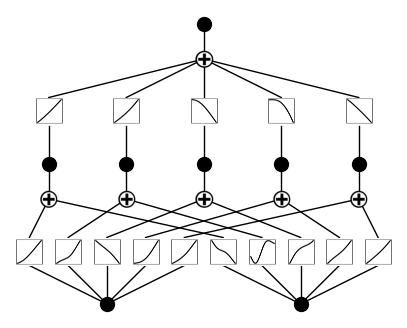

In [ ]:
import torch
import numpy as np

##create a dataset
def create_dataset(f, n_var=2, n_samples=1000, split_ratio=0.8):

    # Generate random input data
    X = torch.rand(n_samples, n_var)

    # Compute the target values
    y = f(X)

    # Split into training and test sets
    split_idx = int(n_samples * split_ratio)
    train_input, test_input = X[:split_idx], X[split_idx:]
    train_label, test_label = y[:split_idx], y[split_idx:]

    return {
        'train_input': train_input,
        'train_label': train_label,
        'test_input': test_input,
        'test_label': test_label
    }

# Define the new function f(x, y) = exp(cos(pi*x) + y^2)
f = lambda x: torch.exp(torch.cos(torch.pi*x[:, [0]]) + x[:, [1]]**2)

dataset = create_dataset(f, n_var=2)

print(dataset['train_input'].shape, dataset['train_label'].shape)
##output: torch.Size([800, 2]) torch.Size([800, 1])


from kan import *
# create a KAN: 2D inputs, 1D output, and 5 hidden neurons.
# cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2,5,1], grid=5, k=3, seed=0)

# plot KAN at initialization
model(dataset['train_input']);
model.plot(beta=100)

| train_loss: 4.62e-02 | test_loss: 5.01e-02 | reg: 2.22e+01 | : 100%|█| 20/20 [00:07<00:00,  2.54it


saving model version 0.1


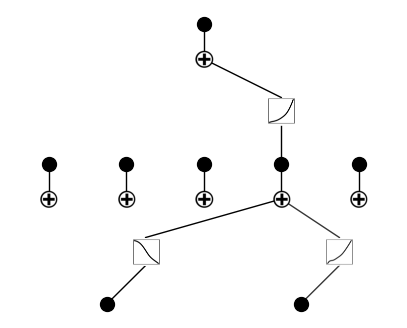

In [ ]:
## train the model

model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01, lamb_entropy=10.)
## output: train loss: 7.23e-02 | test loss: 8.59e-02
## output: | reg: 3.16e+01 : 100%|██| 20/20 [00:11<00:00,  1.69it/s]

model.plot()

tensor([[-1.0000, -0.6000, -0.2000,  0.2000,  0.6000,  1.0000]])
tensor([[-2.2000, -1.8000, -1.4000, -1.0000, -0.6000, -0.2000,  0.2000,  0.6000,
          1.0000,  1.4000,  1.8000,  2.2000]])
torch.Size([1, 1001])
torch.Size([1, 1001, 8])


Text(0, 0.5, 'B_i(x)')

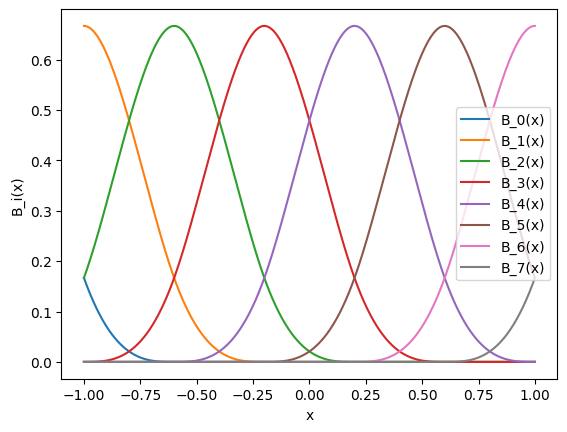

In [ ]:
from kan.spline import B_batch
import torch
import matplotlib.pyplot as plt
import numpy as np
from kan.spline import extend_grid

# consider a 1D example.
# Suppose we have grid in [-1,1] with G intervals, spline order k
G = 5
k = 3
grid = torch.linspace(-1,1,steps=G+1)[None,:]
print(grid)

grid = extend_grid(grid, k_extend=k)
print(grid)

# and we have sample range in [-1,1]
x = torch.linspace(-1,1,steps=1001)[None,:]
print(x.shape)

basis = B_batch(x, grid, k=k)
print(basis.shape)

for i in range(G+k):
    plt.plot(x[0].detach().numpy(), basis[0,:,i].detach().numpy())

plt.legend(['B_{}(x)'.format(i) for i in np.arange(G+k)])
plt.xlabel('x')
plt.ylabel('B_i(x)')

In [ ]:
from kan import KAN

model = KAN(width=[1,1], grid=G, k=k)
# obtain coefficients c_i
print(model.act_fun[0].coef[0].shape)
assert(model.act_fun[0].coef[0].shape[1] == G+k)

# the model forward
print(x[0][:,None])
model_output = model(x[0][:,None])

# spline output
spline_output = torch.einsum('j,ij->i',model.act_fun[0].coef[0][0], basis[0])[:,None]

torch.mean((model_output - spline_output)**2)

checkpoint directory created: ./model
saving model version 0.0
torch.Size([1, 8])
tensor([[-1.0000],
        [-0.9980],
        [-0.9960],
        ...,
        [ 0.9960],
        [ 0.9980],
        [ 1.0000]])


tensor(0.0040, grad_fn=<MeanBackward0>)

In [ ]:
model = KAN(width=[1,1], grid=G, k=k)
print(model.act_fun[0].grid) # by default, the grid is in [-1,1]
x = torch.linspace(-10,10,steps = 1001)[:,None]
model.update_grid_from_samples(x)
print(model.act_fun[0].grid) # now the grid becomes in [-10,10]. We add a 0.01 margin in case x have zero variance

checkpoint directory created: ./model
saving model version 0.0
Parameter containing:
tensor([[-2.2000, -1.8000, -1.4000, -1.0000, -0.6000, -0.2000,  0.2000,  0.6000,
          1.0000,  1.4000,  1.8000,  2.2000]])
Parameter containing:
tensor([[-22.0000, -18.0000, -14.0000, -10.0000,  -6.0000,  -2.0000,   2.0000,
           6.0000,  10.0000,  14.0000,  18.0000,  22.0000]])


In [ ]:
# uniform grid
model = KAN(width=[1,1], grid=G, k=k)
print(model.act_fun[0].grid) # by default, the grid is in [-1,1]
x = torch.normal(0,1,size=(1000,1))
model.update_grid_from_samples(x)
print(model.act_fun[0].grid) # now the grid becomes in [-10,10]. We add a 0.01 margin in case x have zero variance

checkpoint directory created: ./model
saving model version 0.0
Parameter containing:
tensor([[-2.2000, -1.8000, -1.4000, -1.0000, -0.6000, -0.2000,  0.2000,  0.6000,
          1.0000,  1.4000,  1.8000,  2.2000]])
Parameter containing:
tensor([[-7.4371, -6.0845, -4.7319, -3.3793, -0.8574, -0.2884,  0.2832,  0.8376,
          3.3837,  4.7363,  6.0889,  7.4415]])


In [ ]:
# adaptive grid based on sample distribution
model = KAN(width=[1,1], grid=G, k=k, grid_eps = 0.)
print(model.act_fun[0].grid) # by default, the grid is in [-1,1]
x = torch.normal(0,1,size=(1000,1))
model.update_grid_from_samples(x)
print(model.act_fun[0].grid) # now the grid becomes in [-10,10]. We add a 0.01 margin in case x have zero variance

checkpoint directory created: ./model
saving model version 0.0
Parameter containing:
tensor([[-2.2000, -1.8000, -1.4000, -1.0000, -0.6000, -0.2000,  0.2000,  0.6000,
          1.0000,  1.4000,  1.8000,  2.2000]])
Parameter containing:
tensor([[-7.4371, -6.0845, -4.7319, -3.3793, -0.8336, -0.2805,  0.2751,  0.8132,
          3.3837,  4.7363,  6.0889,  7.4415]])


In [ ]:
from kan import *
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset = create_dataset(f, n_var=2, device=device)
dataset['train_input'].shape, dataset['train_label'].shape

cpu


(torch.Size([1000, 2]), torch.Size([1000, 1]))

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.32e-02 | test_loss: 4.33e-02 | reg: 1.02e+01 | : 100%|█| 20/20 [00:13<00:00,  1.45it


saving model version 0.1


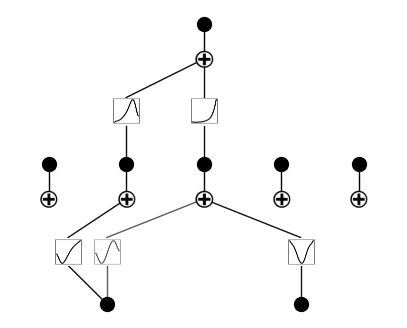

In [ ]:
#train the model
model = KAN(width=[2,5,1], grid=5, k=3, seed=1, device=device)
model.fit(dataset, opt="LBFGS", steps=20, lamb=0.01);
model.plot()

In [ ]:
import torch
from kan.spline import B_batch
x = torch.rand(50,2)
print(x.shape)
print(x)
grid = torch.linspace(-1,1,steps=11)[None, :].expand(2, 11)
print(grid.shape)
print(grid)
B_batch(x, grid, k=3).shape

torch.Size([50, 2])
tensor([[0.5808, 0.1923],
        [0.3386, 0.3942],
        [0.6462, 0.1756],
        [0.7409, 0.7752],
        [0.9654, 0.5663],
        [0.5352, 0.4100],
        [0.0518, 0.3701],
        [0.3875, 0.4171],
        [0.4300, 0.2536],
        [0.9581, 0.3947],
        [0.0273, 0.4316],
        [0.9381, 0.0925],
        [0.5713, 0.7163],
        [0.9954, 0.8154],
        [0.7586, 0.7543],
        [0.5294, 0.0497],
        [0.4833, 0.0531],
        [0.2687, 0.9959],
        [0.3415, 0.4775],
        [0.6957, 0.7065],
        [0.8325, 0.0274],
        [0.6489, 0.9802],
        [0.9228, 0.3329],
        [0.0107, 0.7670],
        [0.5612, 0.7661],
        [0.1031, 0.2413],
        [0.9671, 0.3829],
        [0.0302, 0.3749],
        [0.7737, 0.0269],
        [0.4564, 0.0150],
        [0.1674, 0.6626],
        [0.0069, 0.2471],
        [0.9945, 0.1738],
        [0.8913, 0.8188],
        [0.1232, 0.0703],
        [0.7549, 0.5972],
        [0.0540, 0.0718],
        [0.5882, 0

torch.Size([50, 2, 7])

In [ ]:
from kan.KANLayer import *
model = KANLayer(in_dim=3, out_dim=5)
x = torch.normal(0,1,size=(15,3))
y, preacts, postacts, postspline = model(x)
y.shape, preacts.shape, postacts.shape, postspline.shape

(torch.Size([15, 5]),
 torch.Size([15, 5, 3]),
 torch.Size([15, 5, 3]),
 torch.Size([15, 5, 3]))